In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Movie Revenue Predictions
Onderzoeksvragen:
1. In hoeverre is de omzet van een film te voorspellen op basis van de populariteit op Facebook en IMDB zelf?
2. In hoeverre is het mogelijk om op basis van plot keywords te voorspellen tot welke genres een film behoort?
3. In hoeverre is het mogelijk om de budget-winst verhouding te voorspellen?

## Het Data Science proces
Voor de eerste verkenning is ons gevraagd om de eerste vier stappen uit te voeren:
1. Data collection
2. Data processing (ook wel data munging)
3. Data cleaning
4. Data exploration & analysis
5. Model building
6. Visualization
7. Communication

## 1. Data Collection
De Data Collection is deels al voor ons gedaan. De dataset `movie.csv` is ons aangeleverd. Echter word voor de opdracht 
gevraagd om deze te combineren met een dataset van derden. Om erachter te komen welke dataset geschikt is om te 
combineren met `movies.csv`zullen wij deze dataset eerst moeten processen, cleanen en exploren.  

Om te zien of de dataset `movie.csv` goed is ingeladen, worden de eerste vijf rijen getoond:

In [2]:
df_movies = pd.read_csv('data/movie.csv')
df_movies.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


### Externe dataset
Onze originele dataset bevat geen data over de schrijvers van deze films. Deze data valt echter wel te reconstrueren met
behulp van andere IMDB datasets. Het gaat hierbij om de volgende datasets:

In [3]:
# These datasets were originally named 'data.tsv', they have been renamed accordingly:
# title.crew.tsv.gz -> crew.tsv
df_crew = pd.read_csv(r"data\imdb\crew.tsv", sep="\t")
df_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [4]:
# name.basics.tsv.gz -> names.tsv
df_names = pd.read_csv(r"data/imdb/names.tsv", sep="\t")
df_names.head()


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0043044,tt0072308,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0117057,tt0037382,tt0038355,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,producer","tt0054452,tt0059956,tt0049189,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,writer,soundtrack","tt0072562,tt0080455,tt0078723,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986"


In [5]:
# title.basics.tst.gz -> titles.tsv
df_titles = pd.read_csv(r"data/imdb/titles.tsv", sep="\t")
df_titles.head()

C:\Users\Caspe\Anaconda3\envs\movie-revenue-predictions\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


## 2. Data Processing
### 2a. Aangeleverde dataset
Ook deze stap is grotendeels voor ons gedaan. De data is goed opgeslagen in een `.csv`-bestand en kan direct worden 
ingelezen in een _Pandas_ DataFrame.

Verder rest ons nog de volgende vier stappen:
1. Het verwijderen van ongewenste kolommen
2. Het aanpassen van onduidelijke kolomnamen
3. Het aanpassen van de volgorde van de kolommen
4. Het aanpassen van enkele datatypen

In [6]:
# Ongewenste kolommen verwijderen
df_movies.drop(["movie_imdb_link", "aspect_ratio"], axis=1, inplace=True)

#Onduidelijke kolomnamen aanpassen
df_movies.rename(columns={'color': 'Colour',
                          'director_name': 'Director',
                          'num_critic_for_reviews': 'Number of critics',
                          'duration': 'Duration',
                          'director_facebook_likes': 'Director FB likes',
                          'actor_3_facebook_likes': 'Actor 3 FB likes',
                          'actor_2_name': 'Actor 2 name',
                          'actor_1_facebook_likes': 'Actor 1 FB likes',
                          'gross': 'Gross',
                          'genres': 'Genres',
                          'actor_1_name': 'Actor 1 name',
                          'movie_title': 'Movie title',
                          'num_voted_users': 'Number of voted users',
                          'cast_total_facebook_likes': 'Total Cast FB likes',
                          'actor_3_name': 'Actor 3 name',
                          'facenumber_in_poster': 'Number of faces on poster',
                          'plot_keywords': 'Plot Keywords',
                          'num_user_for_reviews': 'Number of user reviews',
                          'language': 'Language',
                          'country': 'Country',
                          'content_rating': 'Age rating',
                          'budget': 'Budget',
                          'title_year': 'Release year',
                          'actor_2_facebook_likes': 'Actor 2 FB likes',
                          'imdb_score': 'IMDB Score',
                          'movie_facebook_likes': 'Movie FB likes'}, inplace=True)

# Volgorde kolommen aanpassen
df_movies = df_movies[['Movie title',
                       'Release year',
                       'Director',
                       'Director FB likes',
                       'Gross',
                       'Budget',
                       'Duration',
                       'Language',
                       'Country',
                       'Colour',
                       'Genres',
                       'IMDB Score',
                       'Number of voted users',
                       'Number of critics',
                       'Number of user reviews',
                       'Age rating',
                       'Total Cast FB likes',
                       'Movie FB likes',
                       'Actor 1 name',
                       'Actor 2 name',
                       'Actor 3 name',
                       'Actor 1 FB likes',
                       'Actor 2 FB likes',
                       'Actor 3 FB likes',
                       'Plot Keywords',
                       'Number of faces on poster',
                       ]]

# Datatypen aanpassen
# 1. Floats omzetten naar integers
#  De dataset bevat geen kolommen die dienen te worden bewaard als float, behalve `IMDB Score`
df_movies_IMDB_Score = df_movies["IMDB Score"]  # Tijdelijke kopie van de kolom `IMDB Score`
df_movies = df_movies.drop('IMDB Score', axis=1).fillna(0).astype(int, errors='ignore') # Waarden omzetten naar integers
df_movies.insert(11, "IMDB Score", df_movies_IMDB_Score)  # `IMDB Score` weer toevoegen aan originele DataFrame
del df_movies_IMDB_Score

# 2. De kolom `Release year` omzettten van integers naar het datetime-datatype
df_movies["Release year"] = pd.to_datetime(df_movies["Release year"], format='%Y', errors='coerce')

Het DataFrame ziet er nu als volgt uit:

In [7]:
df_movies.head()

,Movie title,Release year,Director,Director FB likes,Gross,Budget,Duration,Language,Country,Colour,...,Total Cast FB likes,Movie FB likes,Actor 1 name,Actor 2 name,Actor 3 name,Actor 1 FB likes,Actor 2 FB likes,Actor 3 FB likes,Plot Keywords,Number of faces on poster
0,Avatar,2009-01-01,James Cameron,0,760505847,237000000,178,English,USA,Color,...,4834,33000,CCH Pounder,Joel David Moore,Wes Studi,1000,936,855,avatar|future|marine|native|paraplegic,0
1,Pirates of the Caribbean: At World's End,2007-01-01,Gore Verbinski,563,309404152,300000000,169,English,USA,Color,...,48350,0,Johnny Depp,Orlando Bloom,Jack Davenport,40000,5000,1000,goddess|marriage ceremony|marriage proposal|pi...,0
2,Spectre,2015-01-01,Sam Mendes,0,200074175,245000000,148,English,UK,Color,...,11700,85000,Christoph Waltz,Rory Kinnear,Stephanie Sigman,11000,393,161,bomb|espionage|sequel|spy|terrorist,1
3,The Dark Knight Rises,2012-01-01,Christopher Nolan,22000,448130642,250000000,164,English,USA,Color,...,106759,164000,Tom Hardy,Christian Bale,Joseph Gordon-Levitt,27000,23000,23000,deception|imprisonment|lawlessness|police offi...,0
4,Star Wars: Episode VII - The Force Awakens ...,NaT,Doug Walker,131,0,0,0,0,0,0,...,143,0,Doug Walker,Rob Walker,0,131,12,0,0,0


### 2b. Extra datasets
Uit de extra datasets moeten een DataFrame worden gemaakt die de volgende kolommen bevat:  
- Movie title
- Director
- Writers
- Actor 1 name
- Actor 2 name
- Actor 3 name

Dit gaat in een paar stappen:
1. Het verwijderen van kolommen die niet gebruikt worden
2. Het samenvoegen van `df_crew` en `df_titles` op `tconst`
3. Het verwijderen van alle rijen die geen films zijn
4. Het toevoegen van de namen van de schrijvers uit `df_names`  
5. Het toevoegen van de kolommen 'Actor # name' uit `df_movies`
6. Het toevoegen van de naam van de directors



In [8]:

# Removing unused columns
df_titles.drop(["isAdult", "endYear", "genres", "runtimeMinutes"], axis=1, inplace=True)
df_names.drop(["birthYear", "deathYear", "primaryProfession", "knownForTitles"], axis=1, inplace=True)

In [9]:
# Joining df_crew and df_titles
df_writers = pd.DataFrame(pd.merge(df_crew, df_titles))

In [10]:
# Dropping all non-movies
df_writers.drop(df_writers[df_writers["titleType"] != "movie"].index, inplace=True)

In `crew.tsv` komen rijen voor met meerdere schrijvers, deze worden voor nu verwaarloost.


In [11]:
# Adding names of writers to `df_writers`
df_writers = pd.DataFrame(df_writers.merge(df_names, left_on="writers", right_on="nconst"))

In [12]:
df_writers.drop(["titleType", "nconst", "tconst", "writers"], axis=1, inplace=True)

In [13]:
df_writers.sample(10)

,directors,primaryTitle,originalTitle,startYear,primaryName
73453,nm1046660,We only live wais,We only live wais,1968,Celso Ad. Castillo
28294,nm1136741,A Superior Schoolboy,Gogyo uryanga,1977,Sam-yuk Yoon
148074,nm2935083,You'll be a Man...,You'll be a Man...,2012,Robert C. Goodwin
86050,nm0805237,Krizno obdobje,Krizno obdobje,1981,Franci Slak
178352,nm5066829,Coming Home: Vietnam,Coming Home: Vietnam,2016,DJ EFN
4616,nm0766581,Aufstieg der kleinen Lilian,Aufstieg der kleinen Lilian,1925,Jane Bess
79275,nm1197967,Ein Sommer auf dem Lande,Ein Sommer auf dem Lande,1969,Georg Lehner
3387,nm0836316,The Upper Crust,The Upper Crust,1917,Charles Sherman
99635,nm0861346,The Lucky Girl,The Lucky Girl,2006,Chris Thorndyke
203197,nm0795290,The Last Ride of Cowboy Bob,The Last Ride of Cowboy Bob,\N,Skip Hollandsworth


In [14]:
# Adding "Actor # name" 1 through 3 to `df_writers`
df_temp_movies = df_movies[["Movie title", "Director", "Actor 1 name", "Actor 2 name", "Actor 3 name"]]
# Renaming "primaryTitle" to "Movie title"
df_writers.rename(columns={"primaryTitle" : "Movie title"}, inplace=True)
# Remove trailing whitespaces from titles
df_temp_movies["Movie title"] = df_temp_movies["Movie title"].str.strip()

# Merge df_writers and df_temp_movies
df_writers = pd.DataFrame(df_writers.merge(df_temp_movies))
del df_temp_movies

C:\Users\Caspe\Anaconda3\envs\movie-revenue-predictions\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# Renaming columns
df_writers.rename(columns={"primaryName" : "Writer", "startYear" : "Release year"}, inplace=True)

# Deleting further unwanted columns
df_writers.drop(["directors", "originalTitle"], axis=1, inplace=True)


Here's a sample of the current version of `df_writers` 

In [16]:
df_writers.sample(5)

,Movie title,Release year,Writer,Director,Actor 1 name,Actor 2 name,Actor 3 name
1214,The Wash,2011,Vered Blonstein,DJ Pooh,Angell Conwell,Dr. Dre,DJ Pooh
636,Revolution,2011,Guy Noland,0,Billy Burke,Tracy Spiridakos,David Lyons
2097,Cast Away,2017,Vitaliy Versace,Robert Zemeckis,Tom Hanks,Paul Sanchez,Nick Searcy
1944,Elizabeth,2013,Eui Yong Zong,Shekhar Kapur,Fanny Ardant,John Gielgud,Eric Cantona
3470,Infamous,\N,Sheldon Turner,Douglas McGrath,Toby Jones,Isabella Rossellini,Hope Davis


## 3. Data Cleaning
### 3a. Aangeleverde dataset
1. Het verwijderen van NaN-types
2. Het verwijderen van dubbele filmtitles
3. Het verwijderen van negatieve waardes

In [17]:
# NaN-types verwijderen
df_movies.dropna(inplace=True)

# Dubbele titels verwijderen
df_movies.sort_values("Release year", inplace=True)  # Sorteren op uitgavejaar
df_movies.drop_duplicates(subset="Movie title", keep="last", inplace=True)  # Alleen meest recente versie blijft bewaard

# Negatieve waardes verwijderen
num = df_movies._get_numeric_data()
num[num < 0] = 0

Na stap 3. Data Cleaning ziet het DataFrame er als volgt uit:

In [18]:
df_movies.head()

,Movie title,Release year,Director,Director FB likes,Gross,Budget,Duration,Language,Country,Colour,...,Total Cast FB likes,Movie FB likes,Actor 1 name,Actor 2 name,Actor 3 name,Actor 1 FB likes,Actor 2 FB likes,Actor 3 FB likes,Plot Keywords,Number of faces on poster
4810,Intolerance: Love's Struggle Throughout the Ages,1916-01-01,D.W. Griffith,204,0,385907,123,0,USA,Black and White,...,481,691,Lillian Gish,Mae Marsh,Walter Long,436,22,9,huguenot|intolerance|medicis|protestant|wedding,1
4958,Over the Hill to the Poorhouse,1920-01-01,Harry F. Millarde,0,3000000,100000,110,0,USA,Black and White,...,4,0,Stephen Carr,Johnnie Walker,Mary Carr,2,2,0,family relationships|gang|idler|poorhouse|thief,1
4885,The Big Parade,1925-01-01,King Vidor,54,0,245000,151,0,USA,Black and White,...,108,226,John Gilbert,Renée Adorée,Claire Adams,81,12,6,chewing gum|climbing a tree|france|translation...,0
2734,Metropolis,1927-01-01,Fritz Lang,756,26435,6000000,145,German,Germany,Black and White,...,203,12000,Brigitte Helm,Gustav Fröhlich,Rudolf Klein-Rogge,136,23,18,art deco|bible quote|dance|silent film|worker,1
4812,The Broadway Melody,1929-01-01,Harry Beaumont,4,2808000,379000,100,English,USA,Black and White,...,109,167,Anita Page,Bessie Love,Charles King,77,28,4,sibling rivalry|singer|sister act|whistling|wi...,8


### 3a. Extra datasets
1. "\\N" waardes omzetten naar NaN-types
2. NaN-types verwijderen
3. Dubbele Movie Titles verwijderen


In [19]:
# Replacing "\N" with None
df_writers.replace("\\N", np.NaN, inplace=True)
# Dropping all rows with NaN-types
df_writers.dropna(inplace=True)

Na stap 3. Data Cleaning ziet `df_writers` er zo uit:

In [20]:
df_writers.sample(5)

,Movie title,Release year,Writer,Director,Actor 1 name,Actor 2 name,Actor 3 name
758,Ishtar,1987,Elaine May,Elaine May,Carol Kane,Warren Beatty,Isabelle Adjani
3472,Red Riding Hood,2011,David Leslie Johnson-McGoldrick,Catherine Hardwicke,Gary Oldman,Billy Burke,Virginia Madsen
1494,Music and Lyrics,2007,Marc Lawrence,Marc Lawrence,Brad Garrett,Scott Porter,Haley Bennett
2155,No Vacancy,2012,Chris Stokes,Chris Stokes,Kristen Quintrall,Rachel Sterling,Black Thomas
2236,The Return,2017,Predrag Jaksic,Andrey Zvyagintsev,Konstantin Lavronenko,Vladimir Garin,Nataliya Vdovina


## 4. Data Exploration & Analysis

Nu de data geprepareerd is kunnen wij onze eerste verkenning gaan uitvoeren. Door middel van describe krijgen we
in een oogopslag een duidelijk beeld van het DataFrame `df_movies`. 

In [21]:
df_movies.describe(include = "all")

,Movie title,Release year,Director,Director FB likes,Gross,Budget,Duration,Language,Country,Colour,...,Total Cast FB likes,Movie FB likes,Actor 1 name,Actor 2 name,Actor 3 name,Actor 1 FB likes,Actor 2 FB likes,Actor 3 FB likes,Plot Keywords,Number of faces on poster
count,4811,4811,4811,4811.000000,4.811000e+03,4.811000e+03,4811.000000,4811,4811,4811,...,4811.000000,4811.000000,4811,4811,4811.0,4811.000000,4811.000000,4811.000000,4811.0,4811.000000
unique,4811,91,2394,NaN,NaN,NaN,NaN,48,66,3,...,NaN,NaN,2042,2962,3450.0,NaN,NaN,NaN,4666.0,NaN
top,It's All Gone Pete Tong,2009-01-01 00:00:00,Steven Spielberg,NaN,NaN,NaN,NaN,English,USA,Color,...,NaN,NaN,Robert De Niro,Morgan Freeman,0.0,NaN,NaN,NaN,0.0,NaN
freq,1,253,26,NaN,NaN,NaN,NaN,4487,3638,4595,...,NaN,NaN,48,18,18.0,NaN,NaN,NaN,138.0,NaN
first,NaN,1916-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,691.402411,4.014763e+07,3.178571e+07,107.789857,NaN,NaN,NaN,...,9724.421950,7410.269798,NaN,NaN,NaN,6595.980877,1642.798587,634.596550,NaN,1.366452
std,NaN,NaN,NaN,2833.794524,6.423202e+07,5.757249e+07,23.195448,NaN,NaN,NaN,...,18322.433435,19336.644963,NaN,NaN,NaN,15233.914377,4046.275798,1638.838988,NaN,2.021966
min,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,NaN,...,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,7.000000,4.639280e+05,3.500000e+06,94.000000,NaN,NaN,NaN,...,1403.500000,0.000000,NaN,NaN,NaN,610.000000,277.000000,130.000000,NaN,0.000000


Enkele verwachtingen:
1. Een film heeft waarschijnlijk meer Facebook likes dan de director.
2. De meeste films zullen winst maken
3. Het meerendeel van de films zullen in het Engels zijn
4. Comedie en Actie zullen waarschijnlijk de meest voorkomende genres zijn.

Testen van de verwachtingen:
1. Gemiddeld heeft een film meer dan 10x zoveel likes dan een director.
2. Gemiddeld brengt een 40 miljoen op en is er een budget van 30 miljoen voor. Echter heeft de opbrengst een
standaard deviatie van 65 miljoen en het budget een standaard deviatie van 79 miljoen. Een goede conclusie is nog niet te geven.
3. 93.3% van de films zijn in het Engels. Dit is een ruime meerderheid.
4. Tegen de verwachtingen in is `Drama` het meest voorkomende genre met 229 maal. Echter valt hier ook nog niks over 
te zeggen omdat veel films meerdere genres bevatten.

Enkele overige observaties:
- Het DataFrame bevat nog 4811 (95.4%) van de originele 5043 rijen 
- `Movie title` bevat zoals beoogd alleen maar nog unieke waarden.
- De gemiddelde IMDB Score van een film is 6.5 met een standaard deviatie van 1.1. De laagste en hoogste scores zijn 1.6 resp. 9.3.
- Het DataFrame bevat films die uitgegeven zijn tussen 1916 en 2016. Een interval van 100 jaar.
- `Actor 3` bestaat uit de meest (3450) verschillende acteurs, gevolgd door `Actor 2 (2962)`en als laatste `Actor 1 (2042)`.

De tien meest voorkomende Directors en Actor 1's zijn:

In [22]:
df_movies["Director"].value_counts()[:10]

Steven Spielberg     26
Woody Allen          22
Martin Scorsese      20
Clint Eastwood       20
Spike Lee            16
Ridley Scott         16
Steven Soderbergh    15
Renny Harlin         15
Tim Burton           14
Oliver Stone         14
Name: Director, dtype: int64

In [23]:
df_movies["Actor 1 name"].value_counts()[:10]

Robert De Niro       48
Johnny Depp          36
Nicolas Cage         32
Matt Damon           29
Denzel Washington    29
J.K. Simmons         29
Bruce Willis         28
Robin Williams       27
Liam Neeson          27
Steve Buscemi        27
Name: Actor 1 name, dtype: int64

De volgende plots zijn slechts voor de eerste analyse van de data. Uiteraard zullen deze nog uitgebreid en verbeterd worden
in de loop van het project. In de volgende scatterplot zijn het budget en de opbrengsten van films geplot. Te zien is dat 
de meeste films niet meer dan 200 miljoen hebben gekost en niet meer dan 400 miljoen opleveren. Enkele uitschieters daargelaten.

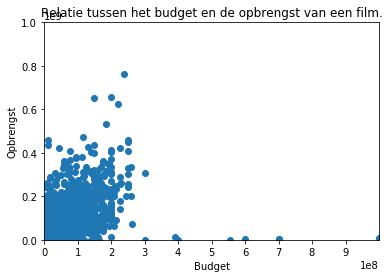

In [24]:
fig, ax = plt.subplots()
plt.title("Relatie tussen het budget en de opbrengst van een film.")
plt.xlabel("Budget")
plt.ylabel("Opbrengst")
plt.xlim(0, 1_000_000_000)
plt.ylim(0, 1_000_000_000)
plt.xticks(np.arange(0, 1_000_000_000, step=100_000_000))
scatter = ax.scatter("Budget", "Gross", data=df_movies)

In de volgende grafiek worden de IMDB scores in het verloop van de tijd geplot. Te zien is dat tot ongeveer 1960 de meeste
films een cijfer tussen de 6 en 9 scoorden. Vanaf 1980 ontstaan er steeds meer films met lagere IMDB score.

C:\Users\Caspe\Anaconda3\envs\movie-revenue-predictions\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


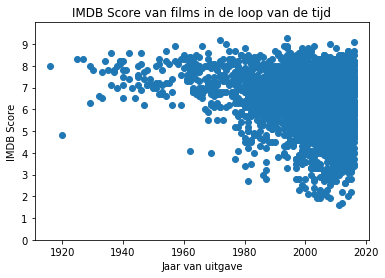

In [25]:
fig, ax = plt.subplots()
plt.title("IMDB Score van films in de loop van de tijd")
plt.xlabel("Jaar van uitgave")
plt.ylabel("IMDB Score")
plt.ylim(0, 10)
plt.yticks(np.arange(0, 10, step=1))
scatter = ax.scatter("Release year", "IMDB Score", data=df_movies)


In de volgende twee boxplots is de spreiding te zien van het budget en de opbrengsten van alle films. Te zien is dat 
het budget van films relatef minder is verspreid dan de opbrengst van de films. De boxplot van de opbrengsten heeft 
tevens veel meer uitschieters.

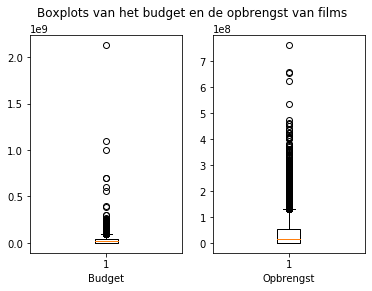

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle("Boxplots van het budget en de opbrengst van films")
ax1.set_xlabel("Budget")
ax2.set_xlabel("Opbrengst")
ax1.boxplot(df_movies["Budget"])
ax2.boxplot(df_movies["Gross"])
plt.show()
